Imports

In [2]:
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
import numpy as np
import pandas as pd
import time

Using Theano backend.


In [3]:
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

### Initial Preprocessing

In [1]:
from pandas import read_csv
data = read_csv('../data/UCI_2010_2014.csv')
data = data.drop('No', axis=1, inplace=False)
data

year  month  day  hour  pm2.5  DEWP  TEMP    PRES cbwd     Iws  Is  Ir
0      2010      1    1     0    NaN   -21 -11.0  1021.0   NW    1.79   0   0
1      2010      1    1     1    NaN   -21 -12.0  1020.0   NW    4.92   0   0
2      2010      1    1     2    NaN   -21 -11.0  1019.0   NW    6.71   0   0
3      2010      1    1     3    NaN   -21 -14.0  1019.0   NW    9.84   0   0
4      2010      1    1     4    NaN   -20 -12.0  1018.0   NW   12.97   0   0
5      2010      1    1     5    NaN   -19 -10.0  1017.0   NW   16.10   0   0
6      2010      1    1     6    NaN   -19  -9.0  1017.0   NW   19.23   0   0
7      2010      1    1     7    NaN   -19  -9.0  1017.0   NW   21.02   0   0
8      2010      1    1     8    NaN   -19  -9.0  1017.0   NW   24.15   0   0
9      2010      1    1     9    NaN   -20  -8.0  1017.0   NW   27.28   0   0
10     2010      1    1    10    NaN   -19  -7.0  1017.0   NW   31.30   0   0
11     2010      1    1    11    NaN   -18  -5.0  1017.0   NW   34.43   0   0
12     2010      1    1    12    NaN   -19  -5.0  1015.0   NW   37.56   0   0
13     2010      1    1    13    NaN   -18  -3.0  1015.0   NW   40.69   0   0
14     2010      1    1    14    NaN   -18  -2.0  1014.0   NW   43.82   0   0
15     2010      1    1    15    NaN   -18  -1.0  1014.0   cv    0.89   0   0
16     2010      1    1    16    NaN   -19  -2.0  1015.0   NW    1.79   0   0
17     2010      1    1    17    NaN   -18  -3.0  1015.0   NW    2.68   0   0
18     2010      1    1    18    NaN   -18  -5.0  1016.0   NE    1.79   0   0
19     2010      1    1    19    NaN   -17  -4.0  1017.0   NW    1.79   0   0
20     2010      1    1    20    NaN   -17  -5.0  1017.0   cv    0.89   0   0
21     2010      1    1    21    NaN   -17  -5.0  1018.0   NW    1.79   0   0
22     2010      1    1    22    NaN   -17  -5.0  1018.0   NW    2.68   0   0
23     2010      1    1    23    NaN   -17  -5.0  1020.0   cv    0.89   0   0
24     2010      1    2     0  129.0   -16  -4.0  1020.0   SE    1.79   0   0
25     2010      1    2     1  148.0   -15  -4.0  1020.0   SE    2.68   0   0
26     2010      1    2     2  159.0   -11  -5.0  1021.0   SE    3.57   0   0
27     2010      1    2     3  181.0    -7  -5.0  1022.0   SE    5.36   1   0
28     2010      1    2     4  138.0    -7  -5.0  1022.0   SE    6.25   2   0
29     2010      1    2     5  109.0    -7  -6.0  1022.0   SE    7.14   3   0
...     ...    ...  ...   ...    ...   ...   ...     ...  ...     ...  ..  ..
43794  2014     12   30    18   79.0   -13   2.0  1020.0   NE    3.58   0   0
43795  2014     12   30    19   35.0    -8   6.0  1021.0   NW    5.81   0   0
43796  2014     12   30    20   26.0   -11   5.0  1022.0   NW   12.96   0   0
43797  2014     12   30    21   20.0   -12   4.0  1023.0   NW   21.90   0   0
43798  2014     12   30    22    8.0   -21   2.0  1025.0   NW   31.73   0   0
43799  2014     12   30    23   16.0   -22   0.0  1026.0   NW   38.88   0   0
43800  2014     12   31     0   10.0   -19  -1.0  1027.0   NW   51.84   0   0
43801  2014     12   31     1   11.0   -18  -1.0  1028.0   NW   61.67   0   0
43802  2014     12   31     2   20.0   -17  -1.0  1028.0   NW   70.61   0   0
43803  2014     12   31     3    9.0   -17  -1.0  1029.0   NW   81.79   0   0
43804  2014     12   31     4    8.0   -19  -2.0  1030.0   NW   94.75   0   0
43805  2014     12   31     5    9.0   -21  -3.0  1030.0   NW  109.95   0   0
43806  2014     12   31     6    8.0   -23  -4.0  1032.0   NW  130.07   0   0
43807  2014     12   31     7    8.0   -22  -5.0  1034.0   NW  143.03   0   0
43808  2014     12   31     8    8.0   -22  -5.0  1034.0   NW  150.18   0   0
43809  2014     12   31     9    8.0   -22  -3.0  1034.0   NW  155.99   0   0
43810  2014     12   31    10    7.0   -22  -2.0  1034.0   NW  163.14   0   0
43811  2014     12   31    11   12.0   -22  -2.0  1034.0   NW  170.29   0   0
43812  2014     12   31    12   17.0   -22   0.0  1033.0   NW  177.44   0   0
43813  2014     12   31    13

In [5]:
data = data.drop(['year','month','day','hour'], axis=1, inplace=False)
data

pm2.5  DEWP  TEMP    PRES cbwd     Iws  Is  Ir
0        NaN   -21 -11.0  1021.0   NW    1.79   0   0
1        NaN   -21 -12.0  1020.0   NW    4.92   0   0
2        NaN   -21 -11.0  1019.0   NW    6.71   0   0
3        NaN   -21 -14.0  1019.0   NW    9.84   0   0
4        NaN   -20 -12.0  1018.0   NW   12.97   0   0
5        NaN   -19 -10.0  1017.0   NW   16.10   0   0
6        NaN   -19  -9.0  1017.0   NW   19.23   0   0
7        NaN   -19  -9.0  1017.0   NW   21.02   0   0
8        NaN   -19  -9.0  1017.0   NW   24.15   0   0
9        NaN   -20  -8.0  1017.0   NW   27.28   0   0
10       NaN   -19  -7.0  1017.0   NW   31.30   0   0
11       NaN   -18  -5.0  1017.0   NW   34.43   0   0
12       NaN   -19  -5.0  1015.0   NW   37.56   0   0
13       NaN   -18  -3.0  1015.0   NW   40.69   0   0
14       NaN   -18  -2.0  1014.0   NW   43.82   0   0
15       NaN   -18  -1.0  1014.0   cv    0.89   0   0
16       NaN   -19  -2.0  1015.0   NW    1.79   0   0
17       NaN   -18  -3.0  1015.0   NW    2.68   0   0
18       NaN   -18  -5.0  1016.0   NE    1.79   0   0
19       NaN   -17  -4.0  1017.0   NW    1.79   0   0
20       NaN   -17  -5.0  1017.0   cv    0.89   0   0
21       NaN   -17  -5.0  1018.0   NW    1.79   0   0
22       NaN   -17  -5.0  1018.0   NW    2.68   0   0
23       NaN   -17  -5.0  1020.0   cv    0.89   0   0
24     129.0   -16  -4.0  1020.0   SE    1.79   0   0
25     148.0   -15  -4.0  1020.0   SE    2.68   0   0
26     159.0   -11  -5.0  1021.0   SE    3.57   0   0
27     181.0    -7  -5.0  1022.0   SE    5.36   1   0
28     138.0    -7  -5.0  1022.0   SE    6.25   2   0
29     109.0    -7  -6.0  1022.0   SE    7.14   3   0
...      ...   ...   ...     ...  ...     ...  ..  ..
43794   79.0   -13   2.0  1020.0   NE    3.58   0   0
43795   35.0    -8   6.0  1021.0   NW    5.81   0   0
43796   26.0   -11   5.0  1022.0   NW   12.96   0   0
43797   20.0   -12   4.0  1023.0   NW   21.90   0   0
43798    8.0   -21   2.0  1025.0   NW   31.73   0   0
43799   16.0   -22   0.0  1026.0   NW   38.88   0   0
43800   10.0   -19  -1.0  1027.0   NW   51.84   0   0
43801   11.0   -18  -1.0  1028.0   NW   61.67   0   0
43802   20.0   -17  -1.0  1028.0   NW   70.61   0   0
43803    9.0   -17  -1.0  1029.0   NW   81.79   0   0
43804    8.0   -19  -2.0  1030.0   NW   94.75   0   0
43805    9.0   -21  -3.0  1030.0   NW  109.95   0   0
43806    8.0   -23  -4.0  1032.0   NW  130.07   0   0
43807    8.0   -22  -5.0  1034.0   NW  143.03   0   0
43808    8.0   -22  -5.0  1034.0   NW  150.18   0   0
43809    8.0   -22  -3.0  1034.0   NW  155.99   0   0
43810    7.0   -22  -2.0  1034.0   NW  163.14   0   0
43811   12.0   -22  -2.0  1034.0   NW  170.29   0   0
43812   17.0   -22   0.0  1033.0   NW  177.44   0   0
43813   11.0   -27   0.0  1032.0   NW  186.38   0   0
43814    9.0   -27   1.0  1032.0   NW  196.21   0   0
43815   11.0   -26   1.0  1032.0   NW  205.15   0   0
43816    8.0   -23   0.0  1032.0   NW  214.09   0   0
43817    9.0   -22  -1.0  1033.0   NW  221.24   0   0
43818   10.0   -22  -2.0  1033.0   NW  226.16   0   0
43819    8.0   -23  -2.0  1034.0   NW  231.97   0   0
43820   10.0   -22  -3.0  1034.0   NW  237.78   0   0
43821   10.0   -22  -3.0  1034.0   NW  242.70   0   0
43822    8.0   -22  -4.0  1034.0   NW  246.72   0   0
43823   12.0   -21  -3.0  1034.0   NW  249.85   0   0

[43824 rows x 8 columns]

In [6]:
data.columns = ['pollution', 'dew', 'temp', 'press', 'wnd_dir', 'wnd_spd', 'snow', 'rain']

In [7]:
# mark all NA values with 0
data['pollution'].fillna(0, inplace=True)
# drop the first 24 hours
data = data[24:]
data.head()
# summarize first 5 rows
print(data.head(5))
# save to file
#data.to_csv('pollution.csv')

    pollution  dew  temp   press wnd_dir  wnd_spd  snow  rain
24      129.0  -16  -4.0  1020.0      SE     1.79     0     0
25      148.0  -15  -4.0  1020.0      SE     2.68     0     0
26      159.0  -11  -5.0  1021.0      SE     3.57     0     0
27      181.0   -7  -5.0  1022.0      SE     5.36     1     0
28      138.0   -7  -5.0  1022.0      SE     6.25     2     0


## Baseline LSTM + room to change network architecture

In [8]:
# load dataset
dataset = read_csv('../data/pollution.csv', header=0, index_col=0)
values = dataset.values
# integer encode direction
encoder = LabelEncoder()
values[:,4] = encoder.fit_transform(values[:,4])
# ensure all data is float
values = values.astype('float32')

#use last 10 days of data (240 hours) to predict specifically the pollution 10 days from now (240 hours later)
num_days_back = 10
hrs_per_day = 24
num_days_ahead = 3
reframed = series_to_supervised(values, num_days_back*hrs_per_day, num_days_ahead*hrs_per_day)
# drop columns we don't want to predict
reframed.drop(reframed.columns[[-7,-6,-5,-4,-3,-2,-1]], axis=1, inplace=True)
print(reframed.head())

# split into train and test sets
values = reframed.values
#values = scaled
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_features = scaler.fit_transform(values[:,:-1])
scaled_label = scaler.fit_transform(values[:,-1].reshape(-1,1))
values = np.column_stack((scaled_features, scaled_label))

"""
train = values[:n_train_hours, :]
test = values[n_train_hours:, :] #make test set 1 year worth of data
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)
 
#print('hiii')
#print(scaled)
# design network
model = Sequential()
model.add(LSTM(128, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(50, activation='tanh'))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
# fit network
start = time.time()
"""

     var1(t-240)  var2(t-240)  var3(t-240)  var4(t-240)  var5(t-240)  \
240        129.0        -16.0         -4.0       1020.0          2.0   
241        148.0        -15.0         -4.0       1020.0          2.0   
242        159.0        -11.0         -5.0       1021.0          2.0   
243        181.0         -7.0         -5.0       1022.0          2.0   
244        138.0         -7.0         -5.0       1022.0          2.0   

     var6(t-240)  var7(t-240)  var8(t-240)  var1(t-239)  var2(t-239)  \
240         1.79          0.0          0.0        148.0        -15.0   
241         2.68          0.0          0.0        159.0        -11.0   
242         3.57          0.0          0.0        181.0         -7.0   
243         5.36          1.0          0.0        138.0         -7.0   
244         6.25          2.0          0.0        109.0         -7.0   

        ...      var8(t+69)  var1(t+70)  var2(t+70)  var3(t+70)  var4(t+70)  \
240     ...             0.0        27.0       -17.0    

"\ntrain = values[:n_train_hours, :]\ntest = values[n_train_hours:, :] #make test set 1 year worth of data\n# split into input and outputs\ntrain_X, train_y = train[:, :-1], train[:, -1]\ntest_X, test_y = test[:, :-1], test[:, -1]\n# reshape input to be 3D [samples, timesteps, features]\ntrain_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))\ntest_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))\nprint(train_X.shape, train_y.shape, test_X.shape, test_y.shape)\n \n#print('hiii')\n#print(scaled)\n# design network\nmodel = Sequential()\nmodel.add(LSTM(128, input_shape=(train_X.shape[1], train_X.shape[2])))\nmodel.add(Dense(50, activation='tanh'))\nmodel.add(Dense(1))\nmodel.compile(loss='mae', optimizer='adam')\n# fit network\nstart = time.time()\n"

In [9]:
# load dataset
dataset = read_csv('../data/pollution.csv', header=0, index_col=0)
values = dataset.values

In [10]:
###################### Can change Epochs, Batch size here #######################
history = model.fit(train_X, train_y, batch_size=72, validation_data=(test_X, test_y), 
                    verbose=1, shuffle=False)
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()
 
# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
end = time.time()
print('This took {} seconds.'.format(end - start))
# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

NameError: name 'model' is not defined

Train on 26280 samples, validate on 17209 samples
Epoch 1/10
26280/26280 [==============================] - 16s - loss: 0.0784 - val_loss: 0.0711
Epoch 2/10
26280/26280 [==============================] - 19s - loss: 0.0701 - val_loss: 0.0710
Epoch 3/10
26280/26280 [==============================] - 31s - loss: 0.0704 - val_loss: 0.0709
Epoch 4/10
26280/26280 [==============================] - 26s - loss: 0.0702 - val_loss: 0.0711
Epoch 5/10
26280/26280 [==============================] - 26s - loss: 0.0717 - val_loss: 0.0717
Epoch 6/10
26280/26280 [==============================] - 32s - loss: 0.0708 - val_loss: 0.0718
Epoch 7/10
26280/26280 [==============================] - 33s - loss: 0.0697 - val_loss: 0.0719
Epoch 8/10
26280/26280 [==============================] - 29s - loss: 0.0694 - val_loss: 0.0721
Epoch 9/10
26280/26280 [==============================] - 27s - loss: 0.0695 - val_loss: 0.0721
Epoch 10/10
26280/26280 [==============================] - 31s - loss: 0.0695 - val_lo

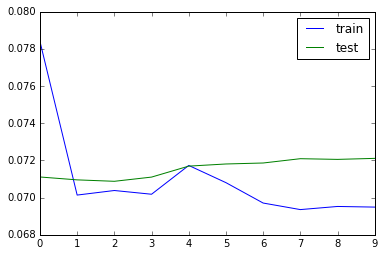

This took 291.01038098335266 seconds.
Activation function = relu, Loss type = mae

Test RMSE: 110.261
Train on 26280 samples, validate on 17209 samples
Epoch 1/10
26280/26280 [==============================] - 14s - loss: 0.0112 - val_loss: 0.0082
Epoch 2/10
26280/26280 [==============================] - 16s - loss: 0.0086 - val_loss: 0.0071
Epoch 3/10
26280/26280 [==============================] - 28s - loss: 0.0083 - val_loss: 0.0084
Epoch 4/10
26280/26280 [==============================] - 24s - loss: 0.0091 - val_loss: 0.0086
Epoch 5/10
26280/26280 [==============================] - 33s - loss: 0.0071 - val_loss: 0.0054
Epoch 6/10
26280/26280 [==============================] - 30s - loss: 0.0060 - val_loss: 0.0045
Epoch 7/10
26280/26280 [==============================] - 25s - loss: 0.0053 - val_loss: 0.0050
Epoch 8/10
26280/26280 [==============================] - 27s - loss: 0.0047 - val_loss: 0.0050
Epoch 9/10
26280/26280 [==============================] - 36s - loss: 0.0039 - v

This took 284.0162489414215 seconds.
Activation function = relu, Loss type = mse

Test RMSE: 67.019
Train on 26280 samples, validate on 17209 samples
Epoch 1/10
26280/26280 [==============================] - 10s - loss: 0.0886 - val_loss: 0.1014
Epoch 2/10
26280/26280 [==============================] - 13s - loss: 0.0660 - val_loss: 0.1291
Epoch 3/10
26280/26280 [==============================] - 24s - loss: 0.0644 - val_loss: 0.0681
Epoch 4/10
26280/26280 [==============================] - 26s - loss: 0.0588 - val_loss: 0.0843
Epoch 5/10
26280/26280 [==============================] - 23s - loss: 0.0535 - val_loss: 0.0690
Epoch 6/10
26280/26280 [==============================] - 23s - loss: 0.0507 - val_loss: 0.0564
Epoch 7/10
26280/26280 [==============================] - 25s - loss: 0.0500 - val_loss: 0.0469
Epoch 8/10
26280/26280 [==============================] - 31s - loss: 0.0480 - val_loss: 0.0872
Epoch 9/10
26280/26280 [==============================] - 31s - loss: 0.0483 - val

This took 254.69041109085083 seconds.
Activation function = sigmoid, Loss type = mae

Test RMSE: 59.426
Train on 26280 samples, validate on 17209 samples
Epoch 1/10
26280/26280 [==============================] - 13s - loss: 0.0111 - val_loss: 0.0082
Epoch 2/10
26280/26280 [==============================] - 21s - loss: 0.0093 - val_loss: 0.0086
Epoch 3/10
26280/26280 [==============================] - 31s - loss: 0.0097 - val_loss: 0.0086
Epoch 4/10
26280/26280 [==============================] - 27s - loss: 0.0094 - val_loss: 0.0085
Epoch 5/10
26280/26280 [==============================] - 26s - loss: 0.0097 - val_loss: 0.0087s: 0.00
Epoch 6/10
26280/26280 [==============================] - 28s - loss: 0.0097 - val_loss: 0.0087
Epoch 7/10
26280/26280 [==============================] - 33s - loss: 0.0098 - val_loss: 0.0087
Epoch 8/10
26280/26280 [==============================] - 31s - loss: 0.0098 - val_loss: 0.0087
Epoch 9/10
26280/26280 [==============================] - 29s - loss: 0

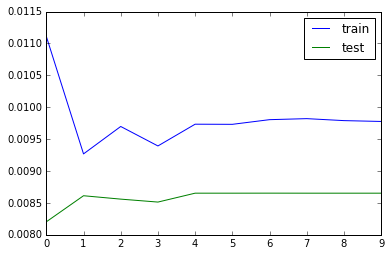

This took 289.56172490119934 seconds.
Activation function = sigmoid, Loss type = mse

Test RMSE: 92.461
Train on 26280 samples, validate on 17209 samples
Epoch 1/10
26280/26280 [==============================] - 20s - loss: 0.0670 - val_loss: 0.0680
Epoch 2/10
26280/26280 [==============================] - 21s - loss: 0.0665 - val_loss: 0.0684
Epoch 3/10
26280/26280 [==============================] - 31s - loss: 0.0662 - val_loss: 0.0675
Epoch 4/10
26280/26280 [==============================] - 28s - loss: 0.0640 - val_loss: 0.0636
Epoch 5/10
26280/26280 [==============================] - 33s - loss: 0.0600 - val_loss: 0.0642
Epoch 6/10
26280/26280 [==============================] - 28s - loss: 0.0546 - val_loss: 0.0647
Epoch 7/10
26280/26280 [==============================] - 26s - loss: 0.0500 - val_loss: 0.0671
Epoch 8/10
26280/26280 [==============================] - 27s - loss: 0.0468 - val_loss: 0.0647
Epoch 9/10
26280/26280 [==============================] - 31s - loss: 0.0451 -

This took 299.1531889438629 seconds.
Activation function = softmax, Loss type = mae

Test RMSE: 87.162
Train on 26280 samples, validate on 17209 samples
Epoch 1/10
26280/26280 [==============================] - 11s - loss: 0.0089 - val_loss: 0.0087
Epoch 2/10
26280/26280 [==============================] - 15s - loss: 0.0088 - val_loss: 0.0087
Epoch 3/10
26280/26280 [==============================] - 30s - loss: 0.0088 - val_loss: 0.0088
Epoch 4/10
26280/26280 [==============================] - 29s - loss: 0.0087 - val_loss: 0.0088
Epoch 5/10
26280/26280 [==============================] - 26s - loss: 0.0087 - val_loss: 0.0088
Epoch 6/10
26280/26280 [==============================] - 27s - loss: 0.0087 - val_loss: 0.0088
Epoch 7/10
26280/26280 [==============================] - 28s - loss: 0.0087 - val_loss: 0.0088
Epoch 8/10
26280/26280 [==============================] - 30s - loss: 0.0087 - val_loss: 0.0088
Epoch 9/10
26280/26280 [==============================] - 27s - loss: 0.0087 - 

This took 269.96571588516235 seconds.
Activation function = softmax, Loss type = mse

Test RMSE: 93.424
Train on 26280 samples, validate on 17209 samples
Epoch 1/10
26280/26280 [==============================] - 11s - loss: 0.0862 - val_loss: 0.0720
Epoch 2/10
26280/26280 [==============================] - 18s - loss: 0.0692 - val_loss: 0.0720
Epoch 3/10
26280/26280 [==============================] - 33s - loss: 0.0690 - val_loss: 0.0717
Epoch 4/10
26280/26280 [==============================] - 31s - loss: 0.0689 - val_loss: 0.0716
Epoch 5/10
26280/26280 [==============================] - 33s - loss: 0.0688 - val_loss: 0.0715
Epoch 6/10
26280/26280 [==============================] - 37s - loss: 0.0687 - val_loss: 0.0714
Epoch 7/10
26280/26280 [==============================] - 31s - loss: 0.0685 - val_loss: 0.0710
Epoch 8/10
26280/26280 [==============================] - 27s - loss: 0.0684 - val_loss: 0.0709
Epoch 9/10
26280/26280 [==============================] - 29s - loss: 0.0683 -

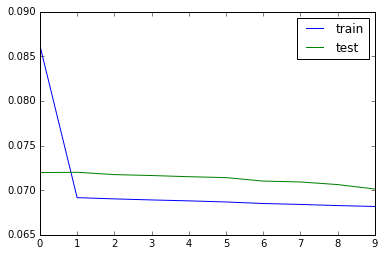

This took 300.24806785583496 seconds.
Activation function = tanh, Loss type = mae

Test RMSE: 107.396
Train on 26280 samples, validate on 17209 samples
Epoch 1/10
26280/26280 [==============================] - 10s - loss: 0.0208 - val_loss: 0.0085
Epoch 2/10
26280/26280 [==============================] - 15s - loss: 0.0086 - val_loss: 0.0082
Epoch 3/10
26280/26280 [==============================] - 31s - loss: 0.0083 - val_loss: 0.0087
Epoch 4/10
26280/26280 [==============================] - 29s - loss: 0.0093 - val_loss: 0.0086
Epoch 5/10
26280/26280 [==============================] - 31s - loss: 0.0093 - val_loss: 0.0087
Epoch 6/10
26280/26280 [==============================] - 25s - loss: 0.0102 - val_loss: 0.0087
Epoch 7/10
26280/26280 [==============================] - 26s - loss: 0.0105 - val_loss: 0.0087
Epoch 8/10
26280/26280 [==============================] - 27s - loss: 0.0102 - val_loss: 0.0087
Epoch 9/10
26280/26280 [==============================] - 30s - loss: 0.0099 - v

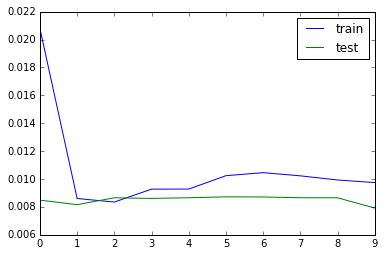

This took 269.3706991672516 seconds.
Activation function = tanh, Loss type = mse

Test RMSE: 88.446
[110.26067302363522, 67.01944097610782, 59.42641071960871, 92.46127250942689, 87.16176815625644, 93.42447651713121, 107.39647540626042, 88.4461402581396]


In [89]:
def try_lstm(train_X, train_y, test_X, test_y, act_fctn, loss_fctn):
    model = Sequential()
    model.add(LSTM(128, input_shape=(train_X.shape[1], train_X.shape[2])))
    model.add(Dense(50, activation=act_fctn))
    model.add(Dense(1))
    model.compile(loss=loss_fctn, optimizer='adam')
    # fit network
    start = time.time()
    
    history = model.fit(train_X, train_y, nb_epoch=10, batch_size=72, validation_data=(test_X, test_y), 
                        verbose=1, shuffle=False)
    # plot history
    pyplot.plot(history.history['loss'], label='train')
    pyplot.plot(history.history['val_loss'], label='test')
    pyplot.legend()
    pyplot.show()

    # make a prediction
    yhat = model.predict(test_X)
    test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
    # invert scaling for forecast
    inv_yhat = concatenate((yhat, test_X[:, 1:]), axis=1)
    inv_yhat = scaler.inverse_transform(inv_yhat)
    inv_yhat = inv_yhat[:,0]
    # invert scaling for actual
    test_y = test_y.reshape((len(test_y), 1))
    inv_y = concatenate((test_y, test_X[:, 1:]), axis=1)
    inv_y = scaler.inverse_transform(inv_y)
    inv_y = inv_y[:,0]
    end = time.time()
    print('This took {} seconds.'.format(end - start))
    # calculate RMSE
    print("Activation function = {}, Loss type = {}\n".format(act_fctn, loss_fctn))
    rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
    print('Test RMSE: %.3f' % rmse) 
    return rmse
    

def try_diff_lstms(train_X, train_y, test_X, test_y):
    act_fctn_list = ['relu', 'sigmoid', 'softmax', 'tanh']
    loss_list = ['mae', 'mse']
    rmse_list = []
    rmse = 0.0
    for act_fctn in act_fctn_list:
        for loss in loss_list:
            rmse = try_lstm(train_X, train_y, test_X, test_y, str(act_fctn), str(loss))
            rmse_list += [rmse,]
    print(rmse_list)
    
    
n_train_hours = (365 * 24) * 3 #make training set 3 years worth of data
train = values[:n_train_hours, :]
test = values[n_train_hours:, :] #make test set 1 year worth of data
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
#print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)
try_diff_lstms(train_X, train_y, test_X, test_y)
            


In [12]:
from random import randint
from numpy import array
from numpy import argmax
from pandas import DataFrame
from pandas import concat
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import TimeDistributed
from keras.layers import RepeatVector

# generate a sequence of random numbers in [0, 99]
def generate_sequence(length=25):
    return [randint(0, 99) for _ in range(length)]

# one hot encode sequence
def one_hot_encode(sequence, n_unique=100):
    encoding = list()
    for value in sequence:
        vector = [0 for _ in range(n_unique)]
        vector[value] = 1
        encoding.append(vector)
    return array(encoding)

# decode a one hot encoded string
def one_hot_decode(encoded_seq):
    return [argmax(vector) for vector in encoded_seq]

# convert encoded sequence to supervised learning
def to_supervised(sequence, n_in, n_out):
    # create lag copies of the sequence
    df = DataFrame(sequence)
    df = concat([df.shift(n_in-i-1) for i in range(n_in)], axis=1)
    # drop rows with missing values
    df.dropna(inplace=True)
    # specify columns for input and output pairs
    values = df.values
    width = sequence.shape[1]
    X = values.reshape(len(values), n_in, width)
    y = values[:, 0:(n_out*width)].reshape(len(values), n_out, width)
    return X, y

# prepare data for the LSTM
def get_data(n_in, n_out, sequence):
    # generate random sequence
    #sequence = generate_sequence()
    # one hot encode
    encoded = one_hot_encode(sequence, len(sequence))
    # convert to X,y pairs
    X,y = to_supervised(encoded, n_in, n_out)
    return X,y



In [ ]:
# define LSTM
n_in = 5
n_out = 5
encoded_length = 20
batch_size = 7
model = Sequential()
model.add(LSTM(20, batch_input_shape=(batch_size, n_in, encoded_length), return_sequences=True, stateful=True))
#model.add(RepeatVector(n_out))
#model.add(LSTM(150, return_sequences=True, stateful=True))
model.add(TimeDistributed(Dense(encoded_length, activation='softmax')))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])
# train LSTM
sequence = data['pollution']
sequence = list(sequence.astype(int))
for epoch in range(10):
    # generate new random sequence
    X,y = get_data(n_in, n_out, sequence)
    # fit model for one epoch on this sequence
    model.fit(X, y, nb_epoch=1, batch_size=batch_size, verbose=2, shuffle=False)
    model.reset_states()
# evaluate LSTM
X,y = get_data(n_in, n_out)
yhat = model.predict(X, batch_size=batch_size, verbose=0)
# decode all pairs
for i in range(len(X)):
    print('Expected:', one_hot_decode(y[i]), 'Predicted', one_hot_decode(yhat[i]))